In [1]:
spark.conf.set("spark.sql.shuffle.partitions", 1000)
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [2]:
from pyspark.ml.clustering import KMeans, KMeansModel, BisectingKMeans, BisectingKMeansModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA, PCAModel, ElementwiseProduct
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.functions import col, sum, greatest, expr, count, countDistinct, max, min, variance, bround, avg, lit, udf
from pyspark.sql import Row
import pandas as pd
import matplotlib.pylab as plt
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import SparseVector, DenseVector

#PARA EL TRATAMIENTO DE OUTLIERS
from pyspark.sql.functions import col, count, when
from functools import reduce
from operator import and_


### Data Importation

In [3]:
dfEM=spark.read.parquet("/analytics/bc1_clustering/tables/dfEM")

In [4]:
#dfBufferOrig=spark.read.parquet("/analytics/bc1_clustering/tables/dfBufferAccYrGrpPart")
#dfBufferOrig=spark.read.parquet("/analytics/bc1_clustering/tables/dfBufferAccYrSubPart2")
# dfBufferOrig=spark.read.parquet("/analytics/bc1_clustering/tables/dfBufferAccYrGrp")
dfBufferOrig=spark.read.parquet("/analytics/bc1_clustering/tables/dfFinalMatrix11Dic")
# dfBufferOrig=dfBufferOrig.withColumnRenamed('','NULO')

In [5]:
# dfBufferOrig.persist()

nameList=dfBufferOrig.schema.names[1:]

len(nameList)

727

In [6]:
dfBufferOrig.count()

4166747

In [6]:
# [dfBuffer, dfTestBuffer] = dfBufferOrig.randomSplit([0.5, 0.5],666)

In [6]:
dfBuffer=dfBufferOrig.where(~dfBufferOrig['ACCOUNTPK'].cast('string').substr(-1,1).isin(['0','1','2','3','4'])).persist()

In [7]:
dfTestBuffer=dfBufferOrig.where(dfBufferOrig['ACCOUNTPK'].cast('string').substr(-1,1).isin(['0','1','2','3','4'])).persist()

In [ ]:
#dfBuffer.write.parquet("/analytics/bc1_clustering/tables/dfTrainBufferBin")

In [ ]:
#dfTestBuffer.write.parquet("/analytics/bc1_clustering/tables/dfTestBufferBin")

In [2]:
# dfBuffer=spark.read.parquet("/analytics/bc1_clustering/tables/dfTrainBufferBin")
# dfBuffer.persist()
# nameList=dfBuffer.schema.names[1:]

In [3]:
# dfTestBuffer=spark.read.parquet("/analytics/bc1_clustering/tables/dfTestBufferBin")
# dfTestBuffer.persist()

DataFrame[ACCOUNTPK: int, 1010540800: int, 1010540900: int, 1010541000: int, 1010541100: int, 1010541200: int, 1010541300: int, 1010541400: int, 1010541500: int, 1010541600: int, 1010541700: int, 1010541800: int, 1010541900: int, 1010542000: int, 1010542100: int, 1010690600: int, 1010690700: int, 1010690800: int, 1010690900: int, 1010751100: int, 1010751200: int, 1010751300: int, 1010751400: int, 1010760500: int, 1010760600: int, 1010760700: int, 1010760800: int, 1010781700: int, 1010781800: int, 1010781900: int, 1010782000: int, 1010790300: int, 1010790400: int, 1010790900: int, 1010791400: int, 1010791500: int, 1010792100: int, 1010792200: int, 1010792300: int, 1010792400: int, 1010792500: int, 1010792600: int, 1010792700: int, 1010792800: int, 1010792900: int, 1010793000: int, 1010793100: int, 1010793200: int, 1010793300: int, 1010793400: int, 1010793500: int, 1010793600: int, 1010793700: int, 1010793800: int, 1010810700: int, 1010810800: int, 1010810900: int, 1010811100: int, 10108

In [8]:
dfBuffer.count()

2067865

In [9]:
dfTestBuffer.count()

2098882

In [ ]:
#dfTestBuffer.select(variance(dfTestBuffer.columns[2])).show()

In [ ]:
#dfBufferOrig.select(dfBufferOrig['ACCOUNTPK'].cast('string').substr(-1,1).alias('caracter')).groupBy('caracter').count().show()

In [9]:
# dfTsys=spark.read.parquet("/analytics/bc1_clustering/tables/dfTsysAccYrOriginal")

In [10]:
# dfTsys.persist()

DataFrame[ACCOUNTPK: bigint, Emprestimo_Pessoal: bigint, Off_Us: bigint, Pagamento_de_Contas: bigint, Parcelamento_Fatura_Automatico: bigint, Parcelamento_Fatura_Facil: bigint, Saque_Parcelado: bigint, Saque_a_Vista: bigint]

In [10]:
dfTsys=dfBufferOrig.select('ACCOUNTPK','Emprestimo_Pessoal','Pagamento_de_Contas','Parcelamento_Fatura_Automatico','Parcelamento_Fatura_Facil','Saque_Parcelado','Saque_a_Vista','Overlimit')

### Binary matrix creation

In [ ]:
dfBufferBinary=dfBufferOrig.select([ i if i=='ACCOUNTPK' else when(col(i)!=0,1).otherwise(0).alias(i) for i in dfBufferOrig.columns])

In [ ]:
dfBufferBinary.persist().count()

In [ ]:
dfBufferBinary.write.parquet("/analytics/bc1_clustering/tables/dfBufferAccYrSubPartBin2")

In [ ]:
# #TEST CONVERSOR A MATRIZ 0/1
# l = [('A',2.0,-3.0,0,-30.0),('B',0,-300.0,1,0),('C',7.0,0.0,2,-50.0),('D',12.0,-700.0,0,0)]
# rdd = sc.parallelize(l)
# dummy = rdd.map(lambda x: Row(ID=x[0], col1=float(x[1]),col2=float(x[2]),col3=float(x[3]),col4=float(x[4])))
# dummyDf = sqlContext.createDataFrame(dummy)
# dummyDf.show(5)
# dummyDf.select([ i if i=='ID' else when(col(i)!=0,1).otherwise(0).alias(i) for i in dummyDf.columns]).show()

### Variable distribution histogram

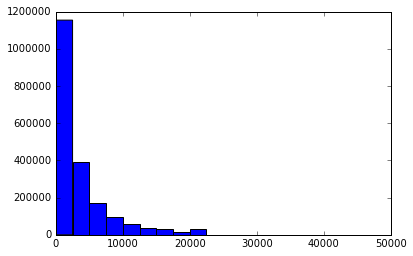

In [15]:
#METODO HISTOGRAM DF
plt.clf()
#bins, counts = dummyDf.select('col1').rdd.flatMap(lambda x: x).histogram(20)
bins, counts = dfBuffer.select('CREDITLIMIT').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)

plt.show()
#.filter(col('101054')>0)

In [ ]:
# #METODO hist DE PLT, parece que no funciona con grandes cantidades de datos
# plt.clf()
# #n, bins, patches = plt.hist(dummyDf.select('col4').collect(), 15, normed=1, facecolor='green', alpha=0.75)
# n, bins, patches = plt.hist(dfBuffer.select('1010540800').collect(), 15, normed=1, facecolor='green', alpha=0.75)
# plt.show()

### Outlier treatment (for money value matrices)

In [ ]:
len(nameList)

In [ ]:
listaCols=[]
listaLimit=[]

for i in nameList:
    cuenta=dfBuffer.filter(col(i)>0).count()
    if cuenta>0:
        listaCols.append(i)
        Q1, Q3 = dfBuffer.filter(col(i)>0).approxQuantile(col=i,probabilities=[0.25,0.75],relativeError=0.01)
        IQR=(Q3-Q1)
        top_limit=Q3+9*IQR
        listaLimit.append(top_limit)

In [ ]:
expr=reduce(and_, [col(c) < t for c, t in zip(listaCols, listaLimit)])

In [ ]:
dfBufferOutlier=dfBuffer.where(expr)

In [ ]:
dfBufferOutlier.persist().count()

In [ ]:
dfBufferOutlier.write.parquet("/analytics/bc1_clustering/tables/dfBufferOutlier")

In [ ]:
dfBufferOutlier=spark.read.parquet("/analytics/bc1_clustering/tables/dfBufferOutlier")

In [ ]:
dfBufferOutlier.count()

### Feature Assembler and Scaler

#### Binary matrices

In [9]:
dfBufferOutlier=dfBuffer
#dfBufferOutlier=dfTestBuffer.select(dfTestBuffer.columns[0:2400])

In [10]:
#continuous_feature_assembler= VectorAssembler(inputCols=dfTestBuffer.columns[0:2400], outputCol="features")
continuous_feature_assembler= VectorAssembler(inputCols=nameList, outputCol="features")

In [11]:
estimatorsKmeans = [continuous_feature_assembler]

featurePipeline = Pipeline(stages=estimatorsKmeans)

sparkFeaturePipelineModel = featurePipeline.fit(dfBufferOutlier)

In [10]:
dfBufferFeature=sparkFeaturePipelineModel.transform(dfBufferOutlier).persist()

In [11]:
dfBufferFeature.count()

1331762

#### Money value matrices

In [11]:
#SI NO SE EJECUTA EL PROCESO DE OUTLIERS
dfBufferOutlier=dfBuffer
#dfBufferOutlier=dfTestBuffer.select(dfTestBuffer.columns[0:2400])

In [12]:
nameList=dfBuffer.schema.names[1:]

In [13]:
continuous_feature_assembler= VectorAssembler(inputCols=nameList, outputCol="unscaled_continuous_features")

In [14]:
continuous_feature_scaler = StandardScaler(inputCol="unscaled_continuous_features", outputCol="scaled_features",\
                                           withStd=True, withMean=True)

In [15]:
estimatorsKmeans = [continuous_feature_assembler, continuous_feature_scaler]

featurePipeline = Pipeline(stages=estimatorsKmeans)

sparkFeaturePipelineModel = featurePipeline.fit(dfBufferOutlier)

In [16]:
dfBufferScaled=sparkFeaturePipelineModel.transform(dfBufferOutlier).persist()

In [17]:
dfBufferScaled.count()

2067865

In [18]:
dfBufferScaled.printSchema()

root
 |-- ACCOUNTPK: long (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- INSTALMENTBALANCEFOROVLMCHECK: double (nullable = true)
 |-- CREDITLIMIT: double (nullable = true)
 |-- LimitUse: double (nullable = true)
 |-- LimitOffUs: double (nullable = true)
 |-- LimitPersLoan: double (nullable = true)
 |-- LimitCashOut: double (nullable = true)
 |-- CLOSING_BALANCE: double (nullable = true)
 |-- INSTALLMENTSOFFERS: long (nullable = true)
 |-- Emprestimo_Pessoal: long (nullable = true)
 |-- Pagamento_de_Contas: long (nullable = true)
 |-- Parcelamento_Fatura_Automatico: long (nullable = true)
 |-- Parcelamento_Fatura_Facil: long (nullable = true)
 |-- Saque_Parcelado: long (nullable = true)
 |-- Saque_a_Vista: long (nullable = true)
 |-- Overlimit: long (nullable = true)
 |-- Overlimit_Auth: integer (nullable = true)
 |-- NULO: double (nullable = true)
 |-- 0742: double (nullable = true)
 |-- 0763: double (nullable = true)
 |-- 0780: double (nullable = true)
 |-- 1520: double

#### Increase of the imporance of the financial variables (money)

In [19]:
listaPesos=([1]*727)
listaPesos[0:17]=[4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4]
VectorPesos=DenseVector(listaPesos)

In [20]:
transformer = ElementwiseProduct(scalingVec=VectorPesos,
                                 inputCol="scaled_features", outputCol="features")
# Batch transform the vectors to create new column:
dfBufferFeature=transformer.transform(dfBufferScaled)

In [21]:
dfBufferFeature.select('scaled_features','features').show(1,truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Dimensionality reduction (WIP)

In [37]:
pca = PCA(k=120, inputCol="features", outputCol="pca_features")

In [38]:
pcamodel = pca.fit(dfBufferFeature)

In [39]:
variance=pcamodel.explainedVariance

In [40]:
variance

DenseVector([0.0448, 0.0177, 0.0059, 0.0051, 0.0045, 0.0041, 0.0033, 0.0033, 0.0031, 0.003, 0.0028, 0.0028, 0.0028, 0.0026, 0.0026, 0.0025, 0.0025, 0.0025, 0.0024, 0.0024, 0.0024, 0.0023, 0.0022, 0.0022, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.002, 0.002, 0.002, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015])

In [41]:
variance.sum()

0.29033780953685812

In [42]:
dfBufferFeaturePCA=pcamodel.transform(dfBufferFeature)

### K Evaluation

In [49]:
listaErrores=[]

for k in range(2,51):
    #print(k)
    kmeans = KMeans().setK(k).setSeed(666)
    #kmeans = BisectingKMeans().setK(k).setSeed(666)
    model = kmeans.fit(dfBufferFeature)
    wssse = model.computeCost(dfBufferFeature)
    print("Within Set Sum of Squared Errors {} = ".format(k) + str(wssse))
    listaErrores.append((k,wssse))

Within Set Sum of Squared Errors 2 = 1393070501.1576726
Within Set Sum of Squared Errors 3 = 1378412741.7343137
Within Set Sum of Squared Errors 4 = 1377461685.790069
Within Set Sum of Squared Errors 5 = 1365889624.0875635
Within Set Sum of Squared Errors 6 = 1363443537.291437
Within Set Sum of Squared Errors 7 = 1362266512.598531
Within Set Sum of Squared Errors 8 = 1360177369.0779493
Within Set Sum of Squared Errors 9 = 1355857063.9648836
Within Set Sum of Squared Errors 10 = 1354647634.1814885
Within Set Sum of Squared Errors 11 = 1349916948.3408916
Within Set Sum of Squared Errors 12 = 1350353189.3224921
Within Set Sum of Squared Errors 13 = 1348084286.237533
Within Set Sum of Squared Errors 14 = 1346759306.167523
Within Set Sum of Squared Errors 15 = 1347960251.390117
Within Set Sum of Squared Errors 16 = 1343489663.5291505
Within Set Sum of Squared Errors 17 = 1340514954.1560385
Within Set Sum of Squared Errors 18 = 1339463624.5741982
Within Set Sum of Squared Errors 19 = 1344000

In [50]:
pdErrors=pd.DataFrame.from_records(listaErrores, columns=['clusters','wssse'])

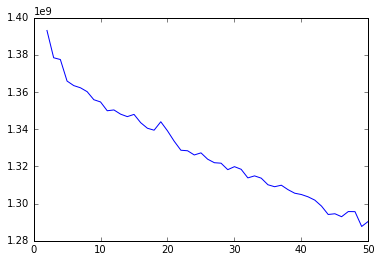

In [51]:
plt.clf()
plt.plot(pdErrors.clusters,pdErrors.wssse)
plt.show()

In [52]:
dfErrors=spark.createDataFrame(pdErrors)

In [ ]:
# dfErrors.write.parquet("/analytics/bc1_clustering/tables/dfErrorsBin")

### Segmentation final model

In [22]:
#kmeans = KMeans().setK(16).setSeed(666)
kmeans = BisectingKMeans().setK(20).setMinDivisibleClusterSize(40000).setSeed(666)

In [23]:
dfBufferFeature.select("ACCOUNTPK","features").show(5)

+---------+--------------------+
|ACCOUNTPK|            features|
+---------+--------------------+
|    67805|[2.13105128210847...|
|   109366|[2.13105128210847...|
|   140126|[-14.216918189454...|
|   142317|[-0.6962453910507...|
|   164347|[2.13105128210847...|
+---------+--------------------+
only showing top 5 rows



In [24]:
model = kmeans.fit(dfBufferFeature)

### Financial Product Inclination

#### Train

In [25]:
dfTrainRes=model.transform(dfBufferFeature).select(col("ACCOUNTPK").alias("ACCOUNT"),"prediction")

In [26]:
dfProdIncl=dfTrainRes.join(dfBuffer,dfTrainRes.ACCOUNT==dfTsys.ACCOUNTPK,'left_outer').fillna(0)

In [27]:
dfProdIncl.printSchema()

root
 |-- ACCOUNT: long (nullable = true)
 |-- prediction: integer (nullable = true)
 |-- ACCOUNTPK: long (nullable = true)
 |-- BALANCE: double (nullable = false)
 |-- INSTALMENTBALANCEFOROVLMCHECK: double (nullable = false)
 |-- CREDITLIMIT: double (nullable = false)
 |-- LimitUse: double (nullable = false)
 |-- LimitOffUs: double (nullable = false)
 |-- LimitPersLoan: double (nullable = false)
 |-- LimitCashOut: double (nullable = false)
 |-- CLOSING_BALANCE: double (nullable = false)
 |-- INSTALLMENTSOFFERS: long (nullable = true)
 |-- Emprestimo_Pessoal: long (nullable = true)
 |-- Pagamento_de_Contas: long (nullable = true)
 |-- Parcelamento_Fatura_Automatico: long (nullable = true)
 |-- Parcelamento_Fatura_Facil: long (nullable = true)
 |-- Saque_Parcelado: long (nullable = true)
 |-- Saque_a_Vista: long (nullable = true)
 |-- Overlimit: long (nullable = true)
 |-- Overlimit_Auth: integer (nullable = true)
 |-- NULO: double (nullable = false)
 |-- 0742: double (nullable = false)

In [28]:
dfProdIncl.createOrReplaceTempView("tProdIncl")

In [29]:
dfClusIncl=spark.sql("""SELECT prediction, 
    SUM(CASE WHEN Emprestimo_Pessoal>0 THEN 1 ELSE 0 END)/SUM(1) Emprestimo_Pessoal,
    SUM(CASE WHEN Pagamento_de_Contas>0 THEN 1 ELSE 0 END)/SUM(1) Pagamento_de_Contas, 
    SUM(CASE WHEN Parcelamento_Fatura_Automatico>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Automatico, 
    SUM(CASE WHEN Parcelamento_Fatura_Facil>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Facil, 
    SUM(CASE WHEN Saque_Parcelado>0 THEN 1 ELSE 0 END)/SUM(1) Saque_Parcelado, 
    SUM(CASE WHEN Saque_a_Vista>0 THEN 1 ELSE 0 END)/SUM(1) Saque_a_Vista,
    SUM(CASE WHEN Overlimit>0 THEN 1 ELSE 0 END)/SUM(1) Overlimit
    from tProdIncl group by prediction order by prediction""")

In [30]:
dfClusIncl.toPandas()

,prediction,Emprestimo_Pessoal,Pagamento_de_Contas,Parcelamento_Fatura_Automatico,Parcelamento_Fatura_Facil,Saque_Parcelado,Saque_a_Vista,Overlimit
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.000055,0.001874,0.013637,0.034406,0.000188,0.000287,0.078817
2,2,0.000461,0.002920,0.010807,0.072358,0.001589,0.002478,0.038822
3,3,0.002085,0.003574,0.009729,0.056132,0.003217,0.002909,0.039523
4,4,0.000066,0.000009,0.000014,0.000033,0.000005,0.000000,0.000014
5,5,0.001151,0.003594,0.005396,0.031596,0.002183,0.002293,0.024218
6,6,0.000163,0.001511,0.002939,0.013186,0.000735,0.000816,0.011227
7,7,0.000000,0.000000,0.000000,0.638970,0.000000,0.000000,0.000000
8,8,0.000000,0.000000,0.000000,0.245920,0.000000,0.000000,1.000000
9,9,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000


In [31]:
dfTrainRes.select("ACCOUNT","prediction").groupBy("prediction").count().orderBy("prediction").toPandas()

,prediction,count
0,0,198175
1,1,180901
2,2,414068
3,3,100727
4,4,212516
5,5,99885
6,6,24495
7,7,116367
8,8,194169
9,9,70631


In [32]:
dfImportanceCluster=spark.sql("""
    SELECT prediction, 
    Emprestimo_Pessoal/AVG_Emprestimo_Pessoal AS Emprestimo_Pessoal, 
    Pagamento_de_Contas/AVG_Pagamento_de_Contas AS Pagamento_de_Contas,
    Parcelamento_Fatura_Automatico/AVG_Parcelamento_Fatura_Automatico AS Parcelamento_Fatura_Automatico,
    Parcelamento_Fatura_Facil/AVG_Parcelamento_Fatura_Facil AS Parcelamento_Fatura_Facil,
    Saque_Parcelado/AVG_Saque_Parcelado  AS Saque_Parcelado,
    Saque_a_Vista/AVG_Saque_a_Vista  AS Saque_a_Vista,
    Overlimit/AVG_Overlimit  AS Overlimit
    FROM
    (SELECT prediction, 
    SUM(CASE WHEN Emprestimo_Pessoal>0 THEN 1 ELSE 0 END)/SUM(1) Emprestimo_Pessoal,
    SUM(CASE WHEN Pagamento_de_Contas>0 THEN 1 ELSE 0 END)/SUM(1) Pagamento_de_Contas, 
    SUM(CASE WHEN Parcelamento_Fatura_Automatico>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Automatico, 
    SUM(CASE WHEN Parcelamento_Fatura_Facil>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Facil, 
    SUM(CASE WHEN Saque_Parcelado>0 THEN 1 ELSE 0 END)/SUM(1) Saque_Parcelado, 
    SUM(CASE WHEN Saque_a_Vista>0 THEN 1 ELSE 0 END)/SUM(1) Saque_a_Vista,
    SUM(CASE WHEN Overlimit>0 THEN 1 ELSE 0 END)/SUM(1) Overlimit
    from tProdIncl group by prediction) CLUSTER CROSS JOIN
    (SELECT  
    SUM(CASE WHEN Emprestimo_Pessoal>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Emprestimo_Pessoal,
    SUM(CASE WHEN Pagamento_de_Contas>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Pagamento_de_Contas, 
    SUM(CASE WHEN Parcelamento_Fatura_Automatico>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Parcelamento_Fatura_Automatico, 
    SUM(CASE WHEN Parcelamento_Fatura_Facil>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Parcelamento_Fatura_Facil, 
    SUM(CASE WHEN Saque_Parcelado>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Saque_Parcelado, 
    SUM(CASE WHEN Saque_a_Vista>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Saque_a_Vista,
    SUM(CASE WHEN Overlimit>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Overlimit
    from tProdIncl)
    WHERE 
    order by prediction""")

In [33]:
dfImportanceCluster.columns[1:]

['Emprestimo_Pessoal',
 'Pagamento_de_Contas',
 'Parcelamento_Fatura_Automatico',
 'Parcelamento_Fatura_Facil',
 'Saque_Parcelado',
 'Saque_a_Vista',
 'Overlimit']

In [34]:
cond = "psf.when" + ".when".join(["(psf.col('" + c + "') == psf.col('max_value'), psf.lit('" + c + "'))" for c in dfImportanceCluster.columns[1:]])
import pyspark.sql.functions as psf
dfImportanceCluster.withColumn("max_value", psf.greatest(*dfImportanceCluster.columns[1:]))\
    .withColumn("MAX", eval(cond))\
    .toPandas()

,prediction,Emprestimo_Pessoal,Pagamento_de_Contas,Parcelamento_Fatura_Automatico,Parcelamento_Fatura_Facil,Saque_Parcelado,Saque_a_Vista,Overlimit,max_value,MAX
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Emprestimo_Pessoal
1,1,0.008651,0.064740,0.120874,0.227135,0.010027,0.013445,0.409695,0.409695,Overlimit
2,2,0.072185,0.100872,0.095791,0.477682,0.084775,0.115901,0.201801,0.477682,Parcelamento_Fatura_Facil
3,3,0.326258,0.123473,0.086235,0.370565,0.171599,0.136061,0.205442,0.370565,Parcelamento_Fatura_Facil
4,4,0.010309,0.000325,0.000125,0.000217,0.000251,0.000000,0.000073,0.010309,Emprestimo_Pessoal
5,5,0.180171,0.124168,0.047829,0.208589,0.116432,0.107238,0.125886,0.208589,Parcelamento_Fatura_Facil
6,6,0.025555,0.052184,0.026053,0.087052,0.039202,0.038191,0.058358,0.087052,Parcelamento_Fatura_Facil
7,7,0.000000,0.000000,0.000000,4.218276,0.000000,0.000000,0.000000,4.218276,Parcelamento_Fatura_Facil
8,8,0.000000,0.000000,0.000000,1.623485,0.000000,0.000000,5.198083,5.198083,Overlimit
9,9,0.000000,0.000000,8.863469,0.000000,0.000000,0.000000,0.000000,8.863469,Parcelamento_Fatura_Automatico


In [35]:
#dfTrainRes.write.parquet("/analytics/bc1_clustering/tables/dfTrainRes")

In [36]:
#dfTrainRes=spark.read.parquet("/analytics/bc1_clustering/tables/dfTrainRes")
#dfTrainRes.persist()

#### Test

In [37]:
dfTestBufferFeatureTmp=sparkFeaturePipelineModel.transform(dfTestBuffer).persist()

In [38]:
dfTestBufferFeature=transformer.transform(dfTestBufferFeatureTmp)

In [39]:
dfTestRes=model.transform(dfTestBufferFeature).select(col("ACCOUNTPK").alias("ACCOUNT"),"prediction")

In [40]:
dfTestProdIncl=dfTestRes.join(dfTsys,dfTestRes.ACCOUNT==dfTsys.ACCOUNTPK,'left_outer').fillna(0)

In [41]:
dfTestProdIncl.printSchema()

root
 |-- ACCOUNT: long (nullable = true)
 |-- prediction: integer (nullable = true)
 |-- ACCOUNTPK: long (nullable = true)
 |-- Emprestimo_Pessoal: long (nullable = true)
 |-- Pagamento_de_Contas: long (nullable = true)
 |-- Parcelamento_Fatura_Automatico: long (nullable = true)
 |-- Parcelamento_Fatura_Facil: long (nullable = true)
 |-- Saque_Parcelado: long (nullable = true)
 |-- Saque_a_Vista: long (nullable = true)
 |-- Overlimit: long (nullable = true)



In [42]:
dfTestProdIncl.createOrReplaceTempView("tTestProdIncl")

In [43]:
dfTestClusIncl=spark.sql("""SELECT prediction, 
    SUM(CASE WHEN Emprestimo_Pessoal>0 THEN 1 ELSE 0 END)/SUM(1) Emprestimo_Pessoal,
    SUM(CASE WHEN Pagamento_de_Contas>0 THEN 1 ELSE 0 END)/SUM(1) Pagamento_de_Contas, 
    SUM(CASE WHEN Parcelamento_Fatura_Automatico>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Automatico, 
    SUM(CASE WHEN Parcelamento_Fatura_Facil>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Facil, 
    SUM(CASE WHEN Saque_Parcelado>0 THEN 1 ELSE 0 END)/SUM(1) Saque_Parcelado, 
    SUM(CASE WHEN Saque_a_Vista>0 THEN 1 ELSE 0 END)/SUM(1) Saque_a_Vista,
    SUM(CASE WHEN Overlimit>0 THEN 1 ELSE 0 END)/SUM(1) Overlimit
    from tTestProdIncl group by prediction order by prediction""")

In [44]:
dfTestClusIncl.toPandas()

,prediction,Emprestimo_Pessoal,Pagamento_de_Contas,Parcelamento_Fatura_Automatico,Parcelamento_Fatura_Facil,Saque_Parcelado,Saque_a_Vista,Overlimit
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.000110,0.001931,0.013371,0.034350,0.000149,0.000276,0.078585
2,2,0.000490,0.002760,0.011377,0.073034,0.001458,0.002500,0.039170
3,3,0.001940,0.003304,0.009231,0.057501,0.003129,0.002749,0.040228
4,4,0.000046,0.000005,0.000023,0.000023,0.000005,0.000005,0.000023
5,5,0.001028,0.003420,0.005762,0.031943,0.002352,0.002332,0.024541
6,6,0.000240,0.001479,0.003397,0.013389,0.000560,0.001119,0.012350
7,7,0.000000,0.000000,0.000000,0.643068,0.000000,0.000000,0.000000
8,8,0.000000,0.000000,0.000000,0.245283,0.000000,0.000000,1.000000
9,9,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000


In [45]:
dfTestRes.select("ACCOUNT","prediction").groupBy("prediction").count().orderBy("prediction").toPandas()

,prediction,count
0,0,198713
1,1,181282
2,2,422419
3,3,102589
4,4,217732
5,5,101179
6,6,25021
7,7,119118
8,8,195346
9,9,72164


#### Total

In [46]:
dfTotal=dfTrainRes.union(dfTestRes)

In [47]:
dfTotalProdIncl=dfTotal.join(dfTsys,dfTrainRes.ACCOUNT==dfTsys.ACCOUNTPK,'left_outer').fillna(0)

In [48]:
dfTotalProdIncl.printSchema()

root
 |-- ACCOUNT: long (nullable = true)
 |-- prediction: integer (nullable = true)
 |-- ACCOUNTPK: long (nullable = true)
 |-- Emprestimo_Pessoal: long (nullable = true)
 |-- Pagamento_de_Contas: long (nullable = true)
 |-- Parcelamento_Fatura_Automatico: long (nullable = true)
 |-- Parcelamento_Fatura_Facil: long (nullable = true)
 |-- Saque_Parcelado: long (nullable = true)
 |-- Saque_a_Vista: long (nullable = true)
 |-- Overlimit: long (nullable = true)



In [49]:
dfTotalProdIncl.createOrReplaceTempView("tTotalProdIncl")

In [50]:
dfTotalClusIncl=spark.sql("""SELECT prediction, 
    SUM(CASE WHEN Emprestimo_Pessoal>0 THEN 1 ELSE 0 END)/SUM(1) Emprestimo_Pessoal,
    SUM(CASE WHEN Pagamento_de_Contas>0 THEN 1 ELSE 0 END)/SUM(1) Pagamento_de_Contas, 
    SUM(CASE WHEN Parcelamento_Fatura_Automatico>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Automatico, 
    SUM(CASE WHEN Parcelamento_Fatura_Facil>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Facil, 
    SUM(CASE WHEN Saque_Parcelado>0 THEN 1 ELSE 0 END)/SUM(1) Saque_Parcelado, 
    SUM(CASE WHEN Saque_a_Vista>0 THEN 1 ELSE 0 END)/SUM(1) Saque_a_Vista,
    SUM(CASE WHEN Overlimit>0 THEN 1 ELSE 0 END)/SUM(1) Overlimit
    from tTotalProdIncl group by prediction order by prediction""")

In [51]:
dfTotalClusIncl.toPandas()

,prediction,Emprestimo_Pessoal,Pagamento_de_Contas,Parcelamento_Fatura_Automatico,Parcelamento_Fatura_Facil,Saque_Parcelado,Saque_a_Vista,Overlimit
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.000083,0.001902,0.013504,0.034378,0.000168,0.000282,0.078701
2,2,0.000476,0.002839,0.011095,0.072699,0.001523,0.002489,0.038998
3,3,0.002012,0.003438,0.009478,0.056823,0.003172,0.002828,0.039879
4,4,0.000056,0.000007,0.000019,0.000028,0.000005,0.000002,0.000019
5,5,0.001089,0.003506,0.005580,0.031771,0.002268,0.002313,0.024380
6,6,0.000202,0.001494,0.003171,0.013289,0.000646,0.000969,0.011794
7,7,0.000000,0.000000,0.000000,0.641043,0.000000,0.000000,0.000000
8,8,0.000000,0.000000,0.000000,0.245600,0.000000,0.000000,1.000000
9,9,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000


In [52]:
dfTotalClusIncl.createOrReplaceTempView("tTotalClusIncl")

In [53]:
dfOrden=spark.sql("""SELECT prediction,Emprestimo_Pessoal, 
    row_number() over (order by Emprestimo_Pessoal desc) as orden
    from  tTotalClusIncl order by Emprestimo_Pessoal desc""")

In [54]:
dfOrden.toPandas()

,prediction,Emprestimo_Pessoal,orden
0,12,0.217581,1
1,13,0.067837,2
2,15,0.026102,3
3,16,0.012838,4
4,19,0.008886,5
5,14,0.007134,6
6,3,0.002012,7
7,11,0.001371,8
8,5,0.001089,9
9,17,0.000544,10


In [55]:
dfTotal.select("ACCOUNT","prediction").groupBy("prediction").count().orderBy("prediction") \
    .withColumn('Percentage', col('count')/dfTotal.count()).toPandas()

,prediction,count,Percentage
0,0,396888,0.095251
1,1,362183,0.086922
2,2,836487,0.200753
3,3,203316,0.048795
4,4,430248,0.103258
5,5,201064,0.048254
6,6,49516,0.011884
7,7,235485,0.056515
8,8,389515,0.093482
9,9,142795,0.034270


In [56]:
dfTotalImportanceCluster=spark.sql("""
    SELECT prediction, 
    Emprestimo_Pessoal/AVG_Emprestimo_Pessoal AS Emprestimo_Pessoal, 
    Pagamento_de_Contas/AVG_Pagamento_de_Contas AS Pagamento_de_Contas,
    Parcelamento_Fatura_Automatico/AVG_Parcelamento_Fatura_Automatico AS Parcelamento_Fatura_Automatico,
    Parcelamento_Fatura_Facil/AVG_Parcelamento_Fatura_Facil AS Parcelamento_Fatura_Facil,
    Saque_Parcelado/AVG_Saque_Parcelado  AS Saque_Parcelado,
    Saque_a_Vista/AVG_Saque_a_Vista  AS Saque_a_Vista,
    Overlimit/AVG_Overlimit  AS Overlimit
    FROM
    (SELECT prediction, 
    SUM(CASE WHEN Emprestimo_Pessoal>0 THEN 1 ELSE 0 END)/SUM(1) Emprestimo_Pessoal,
    SUM(CASE WHEN Pagamento_de_Contas>0 THEN 1 ELSE 0 END)/SUM(1) Pagamento_de_Contas, 
    SUM(CASE WHEN Parcelamento_Fatura_Automatico>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Automatico, 
    SUM(CASE WHEN Parcelamento_Fatura_Facil>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Facil, 
    SUM(CASE WHEN Saque_Parcelado>0 THEN 1 ELSE 0 END)/SUM(1) Saque_Parcelado, 
    SUM(CASE WHEN Saque_a_Vista>0 THEN 1 ELSE 0 END)/SUM(1) Saque_a_Vista,
    SUM(CASE WHEN Overlimit>0 THEN 1 ELSE 0 END)/SUM(1) Overlimit
    from tTotalProdIncl group by prediction) CLUSTER CROSS JOIN
    (SELECT  
    SUM(CASE WHEN Emprestimo_Pessoal>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Emprestimo_Pessoal,
    SUM(CASE WHEN Pagamento_de_Contas>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Pagamento_de_Contas, 
    SUM(CASE WHEN Parcelamento_Fatura_Automatico>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Parcelamento_Fatura_Automatico, 
    SUM(CASE WHEN Parcelamento_Fatura_Facil>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Parcelamento_Fatura_Facil, 
    SUM(CASE WHEN Saque_Parcelado>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Saque_Parcelado, 
    SUM(CASE WHEN Saque_a_Vista>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Saque_a_Vista,
    SUM(CASE WHEN Overlimit>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Overlimit
    from tTotalProdIncl)
    WHERE 
    order by prediction""")

In [57]:
dfTotalImportanceCluster.columns[1:]

['Emprestimo_Pessoal',
 'Pagamento_de_Contas',
 'Parcelamento_Fatura_Automatico',
 'Parcelamento_Fatura_Facil',
 'Saque_Parcelado',
 'Saque_a_Vista',
 'Overlimit']

In [58]:
cond = "psf.when" + ".when".join(["(psf.col('" + c + "') == psf.col('max_value'), psf.lit('" + c + "'))" for c in dfTotalImportanceCluster.columns[1:]])
import pyspark.sql.functions as psf
dfTotalImportanceCluster.withColumn("max_value", psf.greatest(*dfTotalImportanceCluster.columns[1:]))\
    .withColumn("MAX", eval(cond))\
    .toPandas()

,prediction,Emprestimo_Pessoal,Pagamento_de_Contas,Parcelamento_Fatura_Automatico,Parcelamento_Fatura_Facil,Saque_Parcelado,Saque_a_Vista,Overlimit,max_value,MAX
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Emprestimo_Pessoal
1,1,0.012874,0.065556,0.119348,0.226250,0.008936,0.013111,0.409819,0.409819,Overlimit
2,2,0.073950,0.097842,0.098058,0.478456,0.080811,0.115873,0.203073,0.478456,Parcelamento_Fatura_Facil
3,3,0.312657,0.118475,0.083764,0.373968,0.168325,0.131661,0.207662,0.373968,Parcelamento_Fatura_Facil
4,4,0.008670,0.000240,0.000164,0.000184,0.000247,0.000108,0.000097,0.008670,Emprestimo_Pessoal
5,5,0.169288,0.120830,0.049318,0.209094,0.120335,0.107666,0.126956,0.209094,Parcelamento_Fatura_Facil
6,6,0.031389,0.051500,0.028022,0.087457,0.034290,0.045129,0.061416,0.087457,Parcelamento_Fatura_Facil
7,7,0.000000,0.000000,0.000000,4.218897,0.000000,0.000000,0.000000,4.218897,Parcelamento_Fatura_Facil
8,8,0.000000,0.000000,0.000000,1.616370,0.000000,0.000000,5.207321,5.207321,Overlimit
9,9,0.000000,0.000000,8.837853,0.000000,0.000000,0.000000,0.000000,8.837853,Parcelamento_Fatura_Automatico


### Cluster Analysis

#### Products

In [59]:
#dfAnalysis=spark.read.parquet("/analytics/bc1_clustering/tables/dfAnalysisBin")
dfAnalysis=spark.read.parquet("/analytics/bc1_clustering/tables/dfAnalysis11Dic")

In [60]:
dfAnalysis.printSchema()

root
 |-- ACCOUNTPK: long (nullable = true)
 |-- PRF_DS_DEPARTAMENTO: string (nullable = true)
 |-- PRF_DS_SETOR: string (nullable = true)
 |-- PURCHASES: double (nullable = true)



In [61]:
dfAnTmp1=dfAnalysis.join(dfTrainRes,dfTrainRes.ACCOUNT==dfAnalysis.ACCOUNTPK)

In [62]:
dfAnTmp1.printSchema()

root
 |-- ACCOUNTPK: long (nullable = true)
 |-- PRF_DS_DEPARTAMENTO: string (nullable = true)
 |-- PRF_DS_SETOR: string (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ACCOUNT: long (nullable = true)
 |-- prediction: integer (nullable = true)



In [63]:
dfAnTmp1.createOrReplaceTempView('tdfAnTmp1')

In [64]:
dfSectorImportance=spark.sql("""SELECT * FROM (
    SELECT prediction, SECTOR, IMPORTANCE, 
    row_number() over (partition by prediction order by IMPORTANCE desc) as orden FROM 
    (
    SELECT prediction, SECTOR, AVGPRED/AVGTOTAL AS IMPORTANCE FROM 
    (SELECT PRF_DS_SETOR as SECTOR, SUM(PURCHASES)/COUNT(DISTINCT ACCOUNT) AS AVGTOTAL
    FROM tdfAnTmp1 GROUP BY PRF_DS_SETOR ORDER BY SECTOR) A,
    (SELECT prediction, PRF_DS_SETOR as SECTORPRED, SUM(PURCHASES)/COUNT(DISTINCT ACCOUNT) AS AVGPRED
    FROM tdfAnTmp1 GROUP BY prediction, PRF_DS_SETOR ORDER BY SECTORPRED) B
    WHERE SECTOR=SECTORPRED ORDER BY prediction, SECTOR) MAIN
    ORDER BY prediction, orden) FINAL
    WHERE orden=1""")
dfSectorImportance.printSchema()

root
 |-- prediction: integer (nullable = true)
 |-- SECTOR: string (nullable = true)
 |-- IMPORTANCE: double (nullable = true)
 |-- orden: integer (nullable = true)



In [65]:
dfSectorImportance.toPandas()

,prediction,SECTOR,IMPORTANCE,orden
0,0,FERRAMENTAS AUTOMOTIVOS,1.324788,1
1,1,HI-FI SOM,0.966116,1
2,2,SERVICOS DIGITAIS,1.460378,1
3,3,VENDAS PAPELAO,3.465537,1
4,4,VASILHAMES,1.440543,1
5,5,SACOLAS,1.135237,1
6,6,SECA,5.420191,1
7,7,VASILHAMES,2.348474,1
8,8,VASILHAMES,1.276361,1
9,9,DROGARIA,1.171146,1


#### Demographic

In [66]:
#LECTURA DE TABLA PARQUET
dfPeople=spark.read.parquet("/analytics/bc1_clustering/tables/dfPeople")
dfPeople=dfPeople.withColumnRenamed("SERNO","PEOPLESERNO").withColumn('YOB',(dfPeople["DOB"]/10000).cast('integer'))
dfAccounts=spark.read.parquet("/analytics/bc1_clustering/tables/dfAccountsRefdate")
dfAccounts=dfAccounts.withColumnRenamed("SERNO","ACCOUNTSERNO").withColumnRenamed("PEOPLESERNO","PEOPLESERNOFK")

In [67]:
dfDemographic=dfTrainRes.join(dfAccounts,dfAccounts.ACCOUNTSERNO==dfTrainRes.ACCOUNT) \
    .join(dfPeople,dfPeople.PEOPLESERNO==dfAccounts.PEOPLESERNOFK) \
    .select('ACCOUNTSERNO','prediction','PEOPLESERNO','SEX','MARITAL_STATUS','YOB').persist()

In [68]:
dfDemographic.createOrReplaceTempView("tDemographic")

In [69]:
dfAge=spark.sql("""SELECT prediction, round(AVG(YOB),0) as cuenta from tDemographic group by prediction order by prediction""")
dfAge.toPandas()

,prediction,cuenta
0,0,1972.0
1,1,1970.0
2,2,1971.0
3,3,1965.0
4,4,1968.0
5,5,1962.0
6,6,1964.0
7,7,1972.0
8,8,1971.0
9,9,1968.0


In [70]:
dfSex=spark.sql("""SELECT A.*, B.total, round(cuenta/total,2) as porcentaje FROM 
    (SELECT prediction, SEX, COUNT(*) as cuenta from tDemographic group by prediction, SEX) A,
    (SELECT prediction, COUNT(*) as total from tDemographic group by prediction) B
    WHERE A.prediction=B.prediction order by prediction, SEX""")
dfSex.toPandas()

,prediction,SEX,cuenta,total,porcentaje
0,0,F,106145,198175,0.54
1,0,M,92030,198175,0.46
2,1,F,95816,180901,0.53
3,1,M,85085,180901,0.47
4,2,F,230642,414068,0.56
5,2,M,183426,414068,0.44
6,3,F,49473,100727,0.49
7,3,M,51254,100727,0.51
8,4,F,147299,212516,0.69
9,4,M,65216,212516,0.31


In [71]:
dfMarital=spark.sql("""SELECT A.*, B.total, round(cuenta/total,2) as porcentaje FROM 
    (SELECT prediction, MARITAL_STATUS, COUNT(*) as cuenta from tDemographic group by prediction, MARITAL_STATUS) A,
    (SELECT prediction, COUNT(*) as total from tDemographic group by prediction) B
    WHERE A.prediction=B.prediction order by prediction, MARITAL_STATUS""")
dfMarital.toPandas()

,prediction,MARITAL_STATUS,cuenta,total,porcentaje
0,0,C,31521,198175,0.16
1,0,D,10962,198175,0.06
2,0,M,89259,198175,0.45
3,0,O,18471,198175,0.09
4,0,S,38996,198175,0.20
5,0,W,8966,198175,0.05
6,1,C,21915,180901,0.12
7,1,D,11420,180901,0.06
8,1,M,89108,180901,0.49
9,1,O,15436,180901,0.09


### Model saving

In [85]:
#Iter2 -> grupo, part, dinero, 6*IQR

In [72]:
model.save("/analytics/bc1_clustering/models/model2DicGrp")

In [73]:
sparkFeaturePipelineModel.save("/analytics/bc1_clustering/models/pipeline12DicGrp")

In [74]:
transformer.save("/analytics/bc1_clustering/models/scaleFinancial12DicGrp")

In [75]:
dfOrden.write.parquet("/analytics/bc1_clustering/tables/dfOrden12DicGrp")

In [11]:
# sparkFeaturePipelineModel=PipelineModel.load("/analytics/bc1_clustering/models/pipelineOriginal")

In [12]:
# model=BisectingKMeansModel.load("/analytics/bc1_clustering/models/modelOriginal")